--- Data Loaded ---
Initial Shape: (569, 31)
diagnosis
M    357
B    212
Name: count, dtype: int64


Severity Feature used: 'mean radius'
Q3 Threshold for Radius: 15.78

--- Engineered Target Distribution ---
priority
Medium    487
Low        76
High        6
Name: count, dtype: int64


Training set size: 455 samples
Testing set size: 114 samples

--- Random Forest Model Training Complete ---

--- Performance Metrics for Resource Priority Prediction ---
Overall Accuracy: 0.9386
Weighted F1-Score: 0.9287 (Better for imbalance)
Macro F1-Score: 0.5718 (Equal weight to each class)

Classification Report:
                     precision    recall  f1-score   support

   Low Priority (0)       1.00      0.60      0.75        15
Medium Priority (1)       0.93      1.00      0.97        98
  High Priority (2)       0.00      0.00      0.00         1

           accuracy                           0.94       114
          macro avg       0.64      0.53      0.57       114
       weighted avg     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


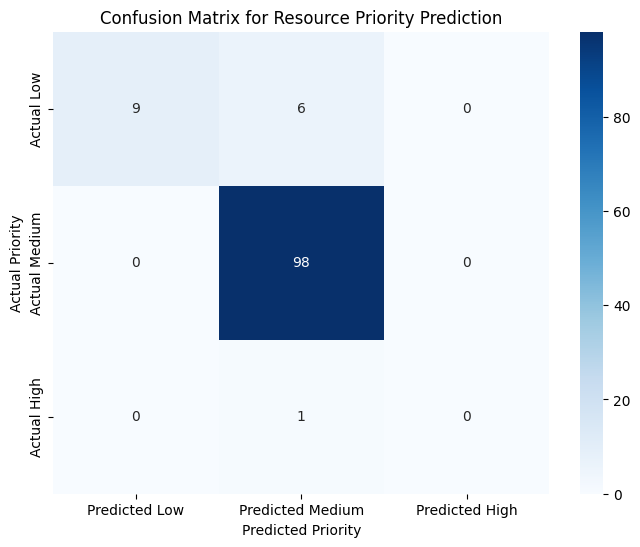

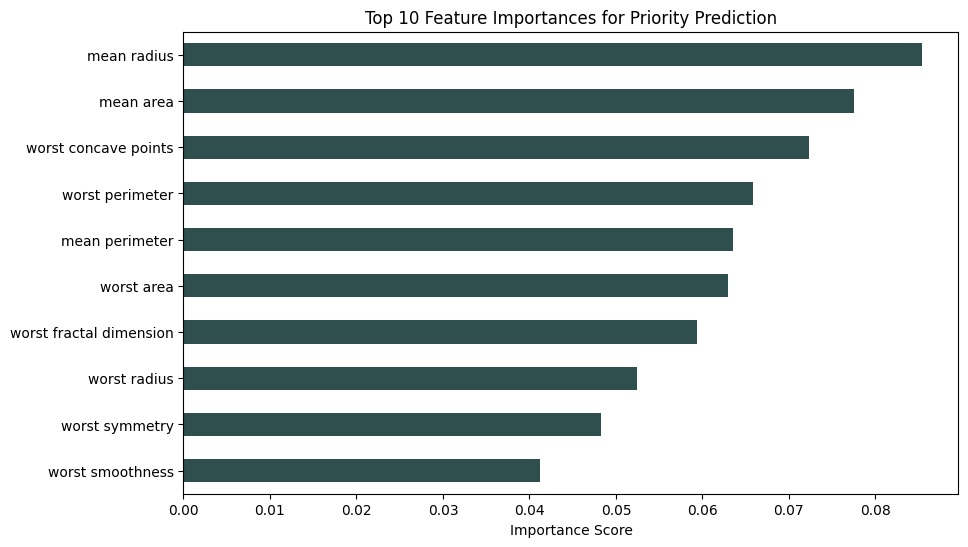


--- Analysis Summary ---
Top 3 Most Important Features: ['mean radius', 'mean area', 'worst concave points']
High recall for 'High Priority' is critical, as misclassifying this (false negatives) means under-allocating resources to severe cases.


In [1]:
# Predictive Analytics for Resource Allocation
# Goal: Train a Random Forest model to predict simulated resource priority (High/Medium/Low)
# based on the Breast Cancer Wisconsin (Diagnostic) Dataset.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Phase 1: Setup and Data Loading ---

# Load the dataset (using scikit-learn's version for guaranteed runnability)
data = load_breast_cancer(as_frame=True)
df = data.frame

# Rename the target column to match the plan's notation and map to M/B
df['diagnosis'] = df['target'].map({0: 'B', 1: 'M'})
df = df.drop(columns=['target'])

print("--- Data Loaded ---")
print(f"Initial Shape: {df.shape}")
print(df['diagnosis'].value_counts())
print("\n" + "="*50 + "\n")


# --- Phase 2: Data Preprocessing and Feature Engineering ---

# 2.1 Initial Cleaning
# In the original WDBC dataset, 'id' is present. The scikit-learn version loads features only.
# No missing values are present in this version, so imputation is skipped.
# We will drop the 'Unnamed: 32' column often found in Kaggle CSVs, but here we don't have it.
# We proceed directly to Target Engineering.

# 2.2 Target Feature Engineering (The Simulation Step)

# 1. Define Severity Metric: Using 'mean radius' (data.feature_names[0])
SEVERITY_FEATURE = 'mean radius'

# 2. Determine Thresholds: Calculate the 75th percentile (Q3) of the chosen severity feature.
# This defines the cut-off for a "large" or "high-risk" tumor size.
Q3_threshold = df[SEVERITY_FEATURE].quantile(0.75)
print(f"Severity Feature used: '{SEVERITY_FEATURE}'")
print(f"Q3 Threshold for Radius: {Q3_threshold:.2f}\n")

# 3. Create the 'priority' column (0=Low, 1=Medium, 2=High)
# Initialize all priorities to Low (0)
df['priority'] = 0

# High Priority (2): Malignant ('M') AND large tumor (radius > Q3)
high_priority_condition = (df['diagnosis'] == 'M') & (df[SEVERITY_FEATURE] > Q3_threshold)
df.loc[high_priority_condition, 'priority'] = 2

# Medium Priority (1): Malignant ('M') OR Benign ('B') with a large tumor (radius > Q3)
# We use OR here, covering Malignant cases not flagged as High, and Benign cases that are large.
medium_priority_condition = (df['diagnosis'] == 'M') | (df[SEVERITY_FEATURE] > Q3_threshold)
df.loc[medium_priority_condition, 'priority'] = 1

# Recalculate High Priority to ensure it overwrites Medium/Low correctly
df.loc[high_priority_condition, 'priority'] = 2

# 4. Final Priority Map check
priority_map = {0: 'Low', 1: 'Medium', 2: 'High'}
print("--- Engineered Target Distribution ---")
print(df['priority'].map(priority_map).value_counts().sort_index(ascending=False))
print("\n" + "="*50 + "\n")

# 2.3 Feature and Target Preparation

# 1. Identify X and y
# Drop the original diagnosis column as the information is now encoded in 'priority'
X = df.drop(columns=['priority', 'diagnosis'])
y = df['priority']

# 2. Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- Phase 3: Model Training and Prediction ---

# 1. Initialize Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train Model
rf_model.fit(X_train_scaled, y_train)
print("\n--- Random Forest Model Training Complete ---\n")

# 3. Prediction
y_pred = rf_model.predict(X_test_scaled)


# --- Phase 4: Evaluation and Reporting ---

print("--- Performance Metrics for Resource Priority Prediction ---")
target_names = ['Low Priority (0)', 'Medium Priority (1)', 'High Priority (2)']

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# 2. F1-Score (Weighted and Macro)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Weighted F1-Score: {f1_weighted:.4f} (Better for imbalance)")
print(f"Macro F1-Score: {f1_macro:.4f} (Equal weight to each class)")

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted Medium', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual Medium', 'Actual High'])
plt.title('Confusion Matrix for Resource Priority Prediction')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

# 5. Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh', color='darkslategray')
plt.title('Top 10 Feature Importances for Priority Prediction')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

print("\n--- Analysis Summary ---")
print(f"Top 3 Most Important Features: {top_10_features.index.tolist()[:3]}")
print("High recall for 'High Priority' is critical, as misclassifying this (false negatives) means under-allocating resources to severe cases.")